In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize':(25,10)})

In [2]:
### Input mutation files

# mutation call positions wrt to the parental_stock.conensus.fasta 
fname_mutations_wild_type = '../../resources/run_workflow/results_cluster/wild_type/all_mutations.csv'
fname_mutations_ko = '../../resources/run_workflow/results_cluster/dicer_KO/all_mutations.csv'
fname_mutations_overexpressed = '../../resources/run_workflow/results_cluster/dicer_overexpression/all_mutations.csv'

# mutation call positions wrt to the EB reference
fname_parental = '../../resources/run_workflow/results_cluster/parental_stock_ref_EBref/all_mutations.csv'

In [3]:
# adapt positions of mutation calls such that all is wrt the EB-reference space
# parental_stock.conensus.fasta 
#
# We are adjusting the parental_stock.consensus.bcftools.fasta sequence such that it excludes the UTRs. 
# This means we exclude positions [0,24] and [9102, 9263] -- those positions all have less than 9999 coverage.

df_wild_type = pd.read_csv(fname_mutations_wild_type)
df_wild_type = df_wild_type.drop(['Unnamed: 0'], axis =1)
df_wild_type['sample'] = 'wild_type'
df_wild_type['Pos'] = df_wild_type['Pos'] + 25

df_ko = pd.read_csv(fname_mutations_ko)
df_ko = df_ko.drop(['Unnamed: 0'], axis =1)
df_ko['sample'] = 'dicer_ko'
df_ko['Pos'] = df_ko['Pos'] + 25

df_overexpressed = pd.read_csv(fname_mutations_overexpressed)
df_overexpressed = df_overexpressed.drop(['Unnamed: 0'], axis =1)
df_overexpressed['sample'] = 'dicer_overexpressed'
df_overexpressed['Pos'] = df_overexpressed['Pos'] + 25

# read in parental strain without shift of positions
df_parental = pd.read_csv(fname_parental)
df_parental = df_parental.drop(['Unnamed: 0'], axis =1)
df_parental['sample'] = 'aaa_parental_stock'
df_parental['date'] = '0'
df_parental['patient'] = '0'

In [4]:
# dataframe with all mutations from all samples
df = pd.concat([df_ko, df_overexpressed, df_wild_type, df_parental])

# add information
df['Frq1'] = pd.to_numeric(df['Frq1'], errors='coerce')
df['Frq2'] = pd.to_numeric(df['Frq2'], errors='coerce')
df['Frq3'] = pd.to_numeric(df['Frq3'], errors='coerce')

df['n_reads_var'] = df['Rvar'] + df['Fvar']
df['n_reads_tot'] = df['Rtot'] + df['Ftot']
df['frequency_reads_var'] = df['n_reads_var'] / df['n_reads_tot']
df['Frq_ave'] = df[['Frq1','Frq2','Frq3']].mean(axis=1)

df['passage'] = df['date'].str.split('_').str[-1].astype('float')
df.to_csv('mutations_all_samples_incl_parental.csv')

In [5]:
# Post-processing filtering of mutation calling

# filter out where Frq_ave == 0.0 
# that is something unexpected happening in ShoRAH which is due to the super high coverage
df = df[df['Frq_ave']!=0]

# strand bias test 
df = df[df['Pval']>=0.05]

# minimum read support
minimum_read_support = 10 
df = df[df['n_reads_var']>=minimum_read_support]

In [6]:
# Filtering for the heatmap plots

# filter mutations that only occurr in one sample 
#unique_position_lists = np.unique(df['Pos'], return_counts = True)
#indx = np.argwhere(unique_position_lists[1]>1)
#multi_occurrence_positions = unique_position_lists[0][indx].flatten()
#df = df[df['Pos'].isin(multi_occurrence_positions)]

# minimum_frequency_threshold = 0.01
#df = df[df['frequency_reads_var']>=minimum_frequency_threshold]

# filter out mutations that show never a frequency >= 0.1 in any sample
frequency_threshold = 0.01
df_temp = df[df['frequency_reads_var']>=frequency_threshold]
df_temp = df_temp[df_temp['sample']!='aaa_parental_stock']
high_freq_positions = df_temp['Pos'].values

df = df[df['Pos'].isin(high_freq_positions)]

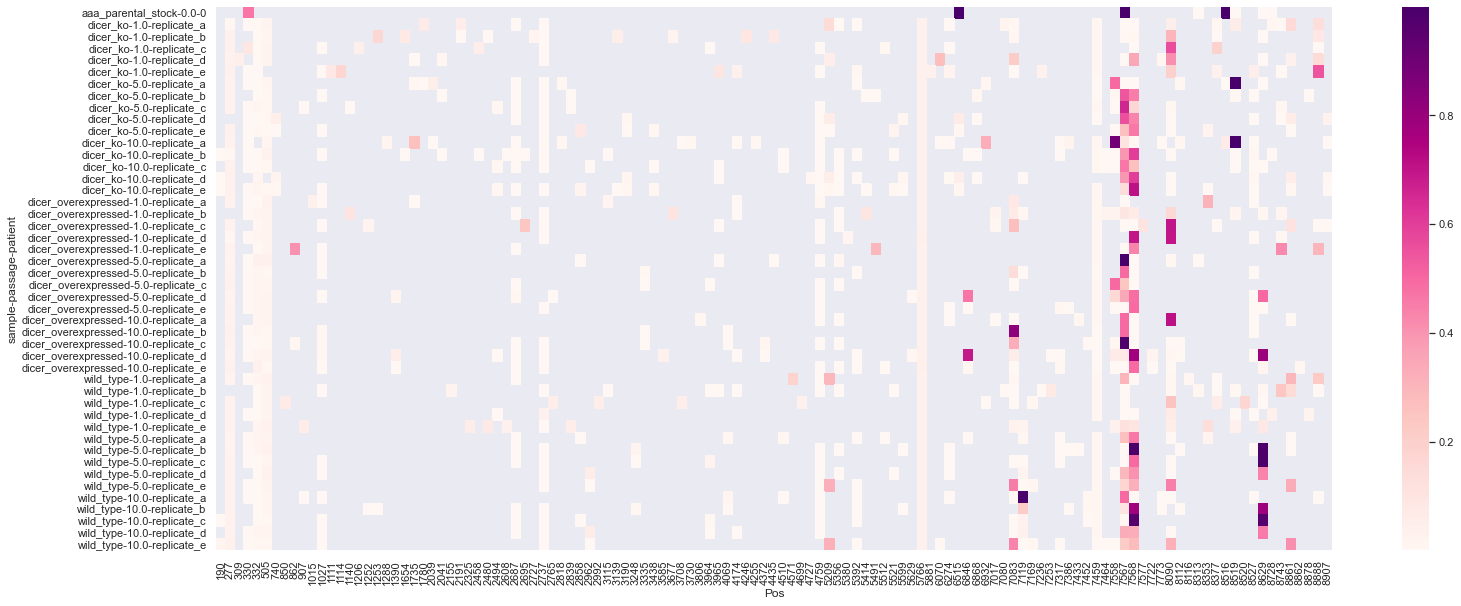

In [7]:
# Pivot table 
df_heatmap = df[['sample', 'patient', 'passage', 'Pos', 'frequency_reads_var']]
df_heatmap = df_heatmap.pivot_table(values='frequency_reads_var', 
                                    index=[ 'sample', 'passage', 'patient'], 
                                    columns='Pos'
                                   )

positions = df_heatmap.columns.to_list()

# plot heatmap in normal scale

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu")
fig = g.get_figure()
#fig.savefig("Heatmap_MutationFrqs.freq_thres0.01.pdf") 

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_78720/2077820153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heatmap['frequency_reads_var_log'] = np.log10(df_heatmap['frequency_reads_var'])


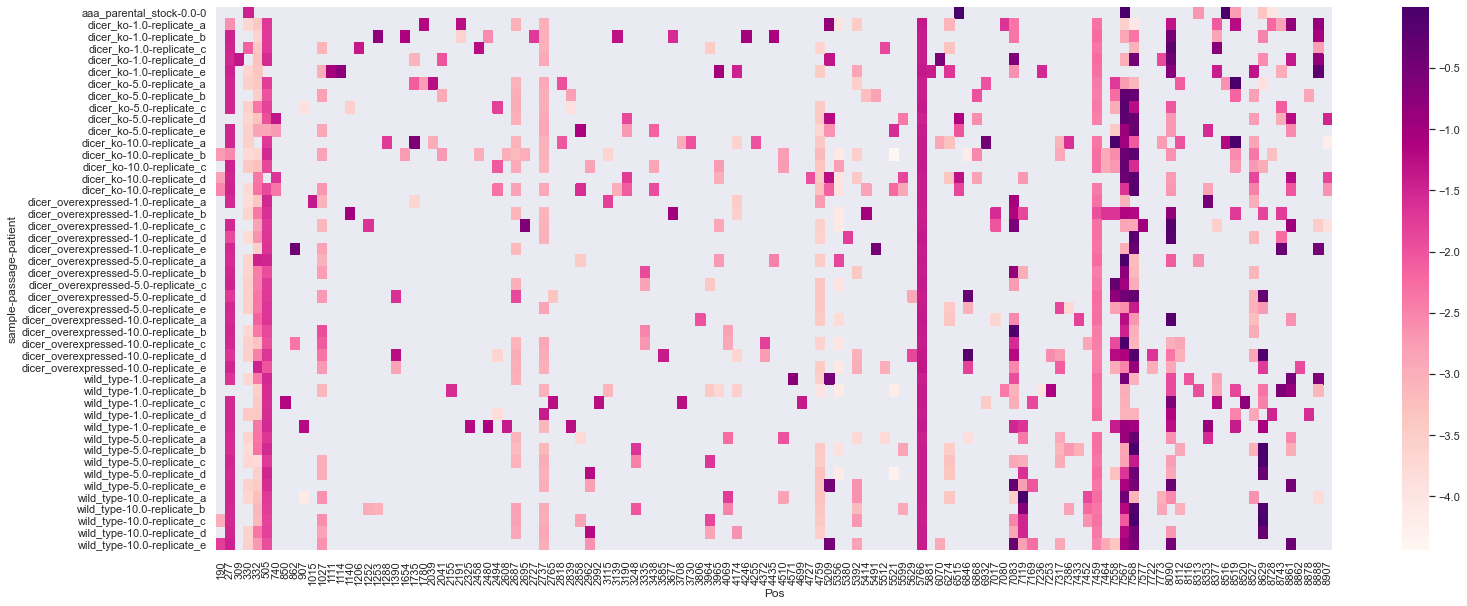

In [8]:
# plot heatmap in log10 scale
df_heatmap = df[['sample', 'patient', 'passage', 'Pos', 'frequency_reads_var']]
df_heatmap['frequency_reads_var_log'] = np.log10(df_heatmap['frequency_reads_var'])

df_heatmap = df_heatmap.pivot_table(values='frequency_reads_var_log', 
                                    index=[ 'sample', 'passage', 'patient'], 
                                    columns='Pos'
                                   )

positions = df_heatmap.columns.to_list()

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu")
fig = g.get_figure()
#fig.savefig("Heatmap_MutationFrqs.log.freq_thres0.01.pdf") 

# Table of polymorphic positions with nucleotide base and frequency

In [37]:
import skbio 
from skbio import Sequence
import pandas as pd 

In [38]:
df_table = df[['sample', 'patient', 'passage', 'Pos', 'Var', 'frequency_reads_var']]
df_table.head(5)

,sample,patient,passage,Pos,Var,frequency_reads_var
3,dicer_ko,replicate_d,10.0,190,G,0.001477
46,dicer_ko,replicate_d,10.0,277,-,0.031810
55,dicer_ko,replicate_d,10.0,332,C,0.000472
56,dicer_ko,replicate_d,10.0,332,T,0.034756
92,dicer_ko,replicate_d,10.0,740,G,0.022210


In [39]:
positions_of_interest = positions

In [40]:
# import the alignment of the other DCV strains (MSA done with MAFFT)

fname_fasta_aln = '../../../DCV_genomes/all_mafft_aln.fasta'

In [41]:
# Read in the aligned sequences

sequences = []
ids_sequences = []

for idx, seq in enumerate(skbio.io.read(fname_fasta_aln, format='fasta')):
        sequences.append(str(seq))
        ids_sequences.append(seq.metadata['id'])
        
df_variation = pd.DataFrame()

genome_length = len(sequences[0])

for position_zero_based in range(genome_length):
    bases = [seq[position_zero_based] for seq in sequences]
    
    if len(set(bases)) > 0:
        df_variation = df_variation.append(
            {
                'position': position_zero_based+1, 
                'aaaa_MG570143.1': bases[0],
                'aaaa_MK645242.1': bases[1],
                'aaaa_MK645238.1':bases[2],
                'aaaa_MK645239.1':bases[3],
                'aaaa_AF014388.1':bases[4],
                'aaaa_NC_001834.1':bases[5],
                'aaaa_MK645241.1':bases[6],
                'aaaa_MK645243.1':bases[7],
                'aaaa_MK645245.1':bases[8],
                'aaaa_MK645240.1':bases[9],
                'aaaa_MK645244.1':bases[10],
            }, 
        ignore_index=True)

In [42]:
df_variation_T = df_variation.T

# use position-row as header
df_variation_T.columns = df_variation_T.iloc[0] 
df_variation_T = df_variation_T[1:]
df_variation_T

position,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,9261.0,9262.0,9263.0,9264.0,9265.0,9266.0,9267.0,9268.0,9269.0,9270.0
aaaa_MG570143.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
aaaa_MK645242.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
aaaa_MK645238.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
aaaa_MK645239.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
aaaa_AF014388.1,T,T,T,A,T,A,T,C,G,T,...,G,T,T,G,T,T,T,T,C,T
aaaa_NC_001834.1,T,T,T,A,T,A,T,C,G,T,...,G,T,T,G,T,T,T,T,C,T
aaaa_MK645241.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
aaaa_MK645243.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
aaaa_MK645245.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
aaaa_MK645240.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [43]:
for idx_row, row in df_variation_T.iterrows():
    
    for pos in positions_of_interest:
        
        df_table = df_table.append(
            {
                'sample': idx_row, 
                'patient': '0',
                'passage': '0',
                'Var': row[pos], 
                'Pos': pos, 
                'frequency_reads_var': 1.0

            }, 
            ignore_index=True)

In [44]:
df_table_pivot = df_table.pivot_table(values=['Var'], 
                                    index=[ 'sample', 'passage', 'patient'], 
                                    columns='Pos', 
                                    aggfunc=lambda x: ', '.join(x), 
                                    fill_value=''
                                   )

In [45]:
df_table_pivot

Var                                 \
Pos                                     190   277  309   330      332  505    
sample              passage patient                                           
aaa_parental_stock  0.0     0                            -, G                 
aaaa_AF014388.1     0       0              A     T    T     A        A    G   
aaaa_MG570143.1     0       0              A     T    T     A        A    G   
aaaa_MK645238.1     0       0              A     T    T     A        A    G   
aaaa_MK645239.1     0       0              A     T    T     A        A    G   
aaaa_MK645240.1     0       0              A     T    T     A        A    G   
aaaa_MK645241.1     0       0              A     T    T     A        A    G   
aaaa_MK645242.1     0       0              A     T    T     A        A    G   
aaaa_MK645243.1     0       0              A     T    T     A        A    G   
aaaa_MK645244.1     0       0              A     T    T     A        A    G   
aaaa_MK645245.1     0       0              A     T    T     A        A    G   
aaaa_NC_001834.1    0       0              A     T    T     A        A    G   
dicer_ko            1.0     replicate_a       -, G          -     C, G    T   
                            replicate_b          -                C, G    T   
                            replicate_c          -       -, G        C    T   
                            replicate_d          -    G              C    T   
                            replicate_e          -          -        C        
                    5.0     replicate_a          -          -        C    T   
                            replicate_b          -                   C    T   
                            replicate_c          -          -     C, T    T   
                            replicate_d                     -        C    T   
                            replicate_e          -          -  C, G, T    T   
                    10.0    replicate_a          -          -             T   
                            replicate_b    G  -, C          -     C, G    T   
                            replicate_c          -          -        C    T   
                            replicate_d    G     -                C, T        
                            replicate_e    G     -          -     C, T    T   
dicer_overexpressed 1.0     replicate_a          -          -        C    T   
                            replicate_b                     -     C, T    T   
                            replicate_c          -             C, G, T    T   
                            replicate_d          -          -     G, T    T   
                            replicate_e          -                C, G    T   
                    5.0     replicate_a          -          -        T    T   
                            replicate_b          -          -     C, T    T   
                            replicate_c          -          -     C, T    T   
                            replicate_d          -          -     C, T    T   
                            replicate_e          -          -     C, T    T   
                    10.0    replicate_a          -                C, T    T   
                            replicate_b          -          -     C, T    T   
                            replicate_c          -          -        C    T   
                            replicate_d          -          -     C, T    T   
                            replicate_e          -                   T    T   
wild_type           1.0     replicate_a          -          -     C, T    T   
                            replicate_b                           C, G    T   
                            replicate_c          -                   C    T   
                            replicate_d          -          -        C    T   
                            replicate_e          -                C, T    T   
                    5.0     replicate_a          -          -     C, T    T   
            

In [46]:
df_table_pivot.to_csv('./heatmaps_mutation_calls/nucleotide_changes_position_wise.csv')

In [47]:
# save the frequency with the base calls
df_table['frequency_reads_var'] = df_table['frequency_reads_var'].round(4)
df_table['frequency_reads_var'] = df_table['frequency_reads_var'].astype(str)
df_table['var-freq'] = df_table['Var']+' ('+df_table['frequency_reads_var'] + ')'

In [48]:
df_table_pivot = df_table.pivot_table(values=['var-freq'], 
                                    index=[ 'sample', 'passage', 'patient'], 
                                    columns='Pos', 
                                    aggfunc=lambda x: ', '.join(x), 
                                    fill_value=''
                                   )

In [56]:
df_table_pivot.to_csv('./heatmaps_mutation_calls/nucleotide_changes_position_wise.freqs.csv')

In [55]:
df_table_pivot['var-freq'] = df_table_pivot['var-freq'].astype(str)

In [52]:
df_table_pivot

var-freq                          \
Pos                                            190                     277    
sample              passage patient                                           
aaa_parental_stock  0.0     0                                                 
aaaa_AF014388.1     0       0               A (1.0)                 T (1.0)   
aaaa_MG570143.1     0       0               A (1.0)                 T (1.0)   
aaaa_MK645238.1     0       0               A (1.0)                 T (1.0)   
aaaa_MK645239.1     0       0               A (1.0)                 T (1.0)   
aaaa_MK645240.1     0       0               A (1.0)                 T (1.0)   
aaaa_MK645241.1     0       0               A (1.0)                 T (1.0)   
aaaa_MK645242.1     0       0               A (1.0)                 T (1.0)   
aaaa_MK645243.1     0       0               A (1.0)                 T (1.0)   
aaaa_MK645244.1     0       0               A (1.0)                 T (1.0)   
aaaa_MK645245.1     0       0               A (1.0)                 T (1.0)   
aaaa_NC_001834.1    0       0               A (1.0)                 T (1.0)   
dicer_ko            1.0     replicate_a               - (0.029), G (0.0002)   
                            replicate_b                          - (0.0331)   
                            replicate_c                           - (0.032)   
                            replicate_d                          - (0.0296)   
                            replicate_e                          - (0.0339)   
                    5.0     replicate_a                          - (0.0309)   
                            replicate_b                          - (0.0309)   
                            replicate_c                          - (0.0303)   
                            replicate_d                                       
                            replicate_e                          - (0.0319)   
                    10.0    replicate_a                          - (0.0303)   
                            replicate_b  G (0.0018)  - (0.0304), C (0.0002)   
                            replicate_c                          - (0.0348)   
                            replicate_d  G (0.0015)              - (0.0318)   
                            replicate_e   G (0.003)              - (0.0324)   
dicer_overexpressed 1.0     replicate_a                          - (0.0277)   
                            replicate_b                                       
                            replicate_c                          - (0.0292)   
                            replicate_d                          - (0.0121)   
                            replicate_e                          - (0.0289)   
                    5.0     replicate_a                          - (0.0269)   
                            replicate_b                          - (0.0301)   
                            replicate_c                          - (0.0327)   
                            replicate_d                          - (0.0196)   
                            replicate_e                          - (0.0297)   
                    10.0    replicate_a                          - (0.0276)   
                            replicate_b                           - (0.032)   
                            replicate_c                          - (0.0294)   
                            replicate_d                          - (0.0223)   
                            replicate_e                          - (0.0316)   
wild_type           1.0     replicate_a                          - (0.0219)   
                            replicate_b                                       
                            replicate_c                          - (0.0289)   
                            replicate_d                          - (0.0289)   
                            replicate_e                          - (0.0289)   
                    5.0     replicate_a                          - (0.0266)   
              